In [ ]:
#| export
print_flag                    = True
check_memory_usage            = True
time_flag                     = True
window_size_percentage        = False
show_plots                    = True
reset_kernel                  = True
pre_configured_case           = False
case_id                       = 1
frequency_factor              = 5
frequency_factor_change_alias = True
check_parameters              = True
cuda_device                   = 1

# MPlot

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks tries to: generate the Mplot for a time series


In [ ]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        " print_flag:", print_flag, "\n",
        "check_memory_usage", check_memory_usage, "\n",
        "time_flag:", time_flag, "\n",
        "window_size_percentage:" , window_size_percentage, "\n",
        "show_plots:",show_plots, "\n",
        "reset_kernel:",reset_kernel, "\n",
        "pre_configured_case:",pre_configured_case, "\n",
        "case_id:",case_id, "\n",
        "frequency_factor:", frequency_factor,  "\n",
        "frequency_factor_change_alias", frequency_factor_change_alias, "\n",
        "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
 print_flag: True 
 check_memory_usage True 
 time_flag: True 
 window_size_percentage: False 
 show_plots: True 
 reset_kernel: True 
 pre_configured_case: False 
 case_id: 1 
 frequency_factor: 5 
 frequency_factor_change_alias True 
 cuda_device 0 



### VsCode update patch
Initial notebook setup when using VSCode.

In [ ]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

In [ ]:
#| export
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#print_flag             = True
#reset_kernel           = True
#check_memory_usage     = True
#time_flag              = True
#window_size_percentage = True
#show_plots             = True

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [ ]:
#| export
import dvats.config as cfg_

In [ ]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [ ]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code
### Import libraries

In [ ]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

### Initialize and Configurate Artifact

#### Setup CUDA

In [ ]:
#| export
wandb_api = wandb.Api()

In [ ]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 517
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 2%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/06_MPlots.ipynb'

TODO: Por ahora está usando solo los datos del base 
 y 02b.yml y definiendo las variables a lo bruto. Está por hacer el definir las cosas en el fichero de configuración.

In [ ]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [ ]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="06_MPlots"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 06_MPlots
alias: Eamonn_Insect_one_million
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (15, 30)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Eamonn_Insect_one_million:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


In [ ]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/06_MPlots.ipynb.


--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


### Generating the MPlots

#### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [ ]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")


alias: Eamonn_Insect_one_million
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [15, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Eamonn_Insect_one_million:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
---> W&B Train Artifact


In [ ]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [ ]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(1000000, 1)


<bound method NDFrame.head of                      Insect_one_million
1970-01-01 00:00:00            0.236820
1970-01-01 00:00:01            0.236820
1970-01-01 00:00:02            0.238040
1970-01-01 00:00:03            0.206300
1970-01-01 00:00:04            0.026855
...                                 ...
1970-01-12 13:46:35            0.014648
1970-01-12 13:46:36            0.030518
1970-01-12 13:46:37            0.034180
1970-01-12 13:46:38            0.013428
1970-01-12 13:46:39           -0.053711

[1000000 rows x 1 columns]>

df_train ~  (1000000, 1)
window_sizes =  [15, 30]
wlen =  30


#### Time series data MPlot

In [ ]:
import dvats.mplots as mplots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp
import dvats.memory as mem

In [ ]:
mem.gpu_memory_status()

GPU | Used mem: 517
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 2%


#### Initialize parameters

In [ ]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

In [ ]:
df_train.columns

Index(['Insect_one_million'], dtype='object')

In [ ]:
ts = df_train.iloc[:, 0].values

---> Aquí habrá que haber pasado por parámetro si se quiere usar una w concreta o que se coja la mejor según la transformada de Fourier

In [ ]:
#Reminder: Mplots works well by getting a w a little bit smaller than the size of your pattern
w = config.w
w

30

In [ ]:
print("Ts ~ ", ts.shape)
print("Expected mp length: ", int(np.floor(ts.shape[0]-w+1)))

Ts ~  (1000000,)
Expected mp length:  999971


#### Tratando de ajustar Piecewise Aggregate Approximation

In [ ]:
max_points = 10000
min = 51250
max = 51250*2

In [ ]:
n_timestamps = max - min 
paa_factor = np.maximum(1, n_timestamps // max_points)

print("N timestamps", max - min)
print("PAA factor:", paa_factor)

n_segments = n_timestamps
for potential_segments in range( np.floor(n_timestamps // paa_factor).astype(int), n_timestamps, +1):
    if n_timestamps % potential_segments == 0:
        n_segments = potential_segments
        break
        
print("N timestamps", max - min)
print("PAA factor:", paa_factor)
print("N segments:", n_segments)
print("Final w:", n_timestamps // ( n_segments))
print("Reminder:", n_timestamps % n_segments)

N timestamps 51250
PAA factor: 5
N timestamps 51250
PAA factor: 5
N segments: 10250
Final w: 5
Reminder: 0


In [ ]:
print("Total samples:", n_timestamps)
print("Original time series size", len(ts))
print("Selected time series size", len(ts[min:max]))

Total samples: 51250
Original time series size 1000000
Selected time series size 51250


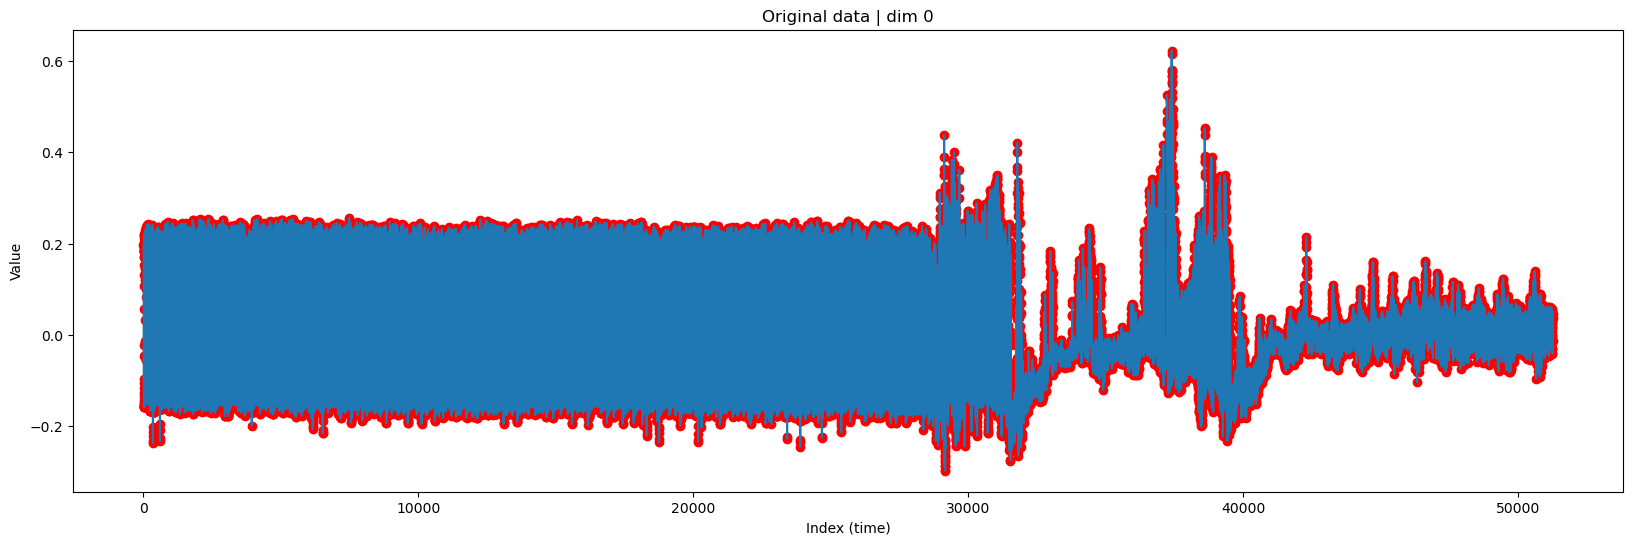

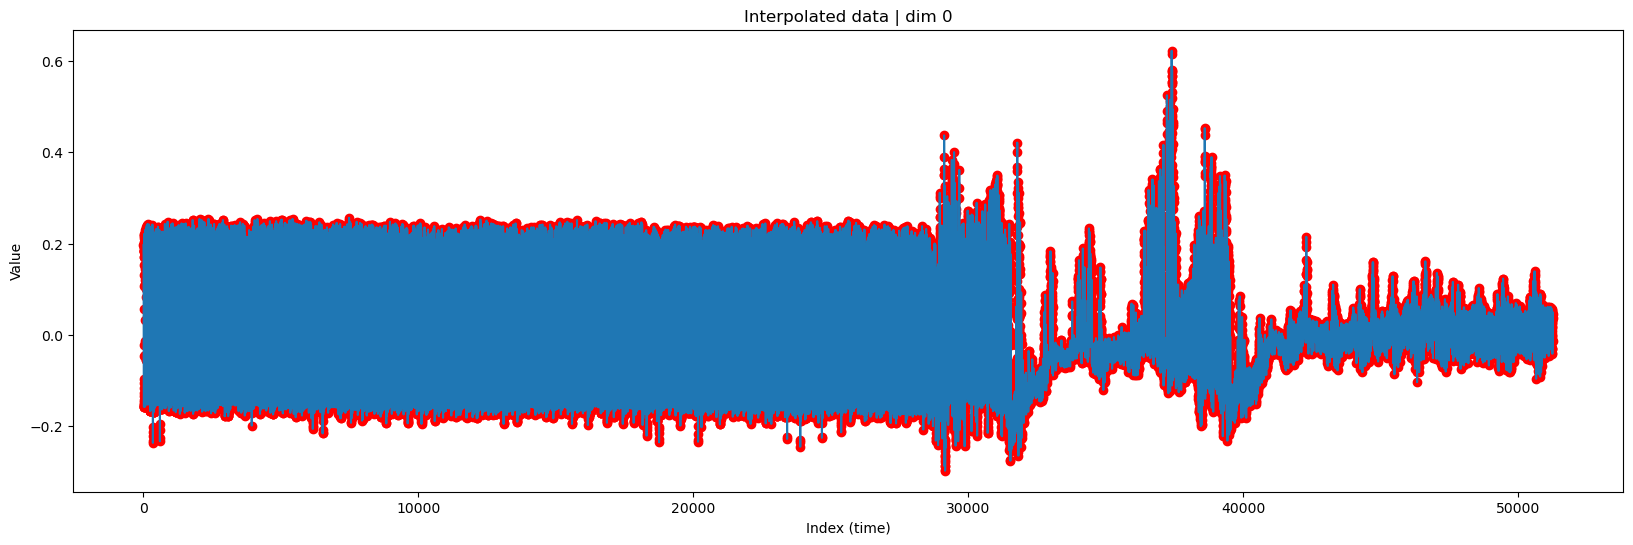

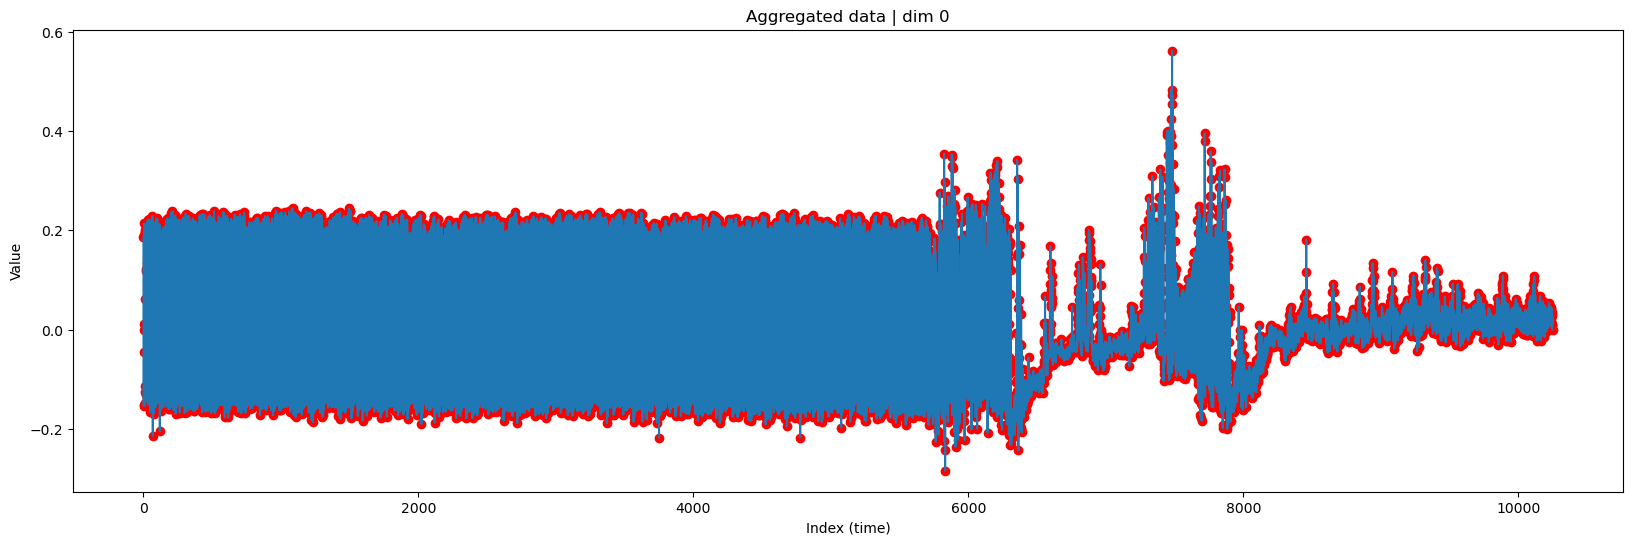

In [ ]:
#| export
paa_pipeline = mplots.Pipeline([
    (
        # Step for interpolating NaNs in the original data
        'interpolator', 
        mplots.Interpolator(
            method             = 'polynomial', 
            n_segments         = n_segments, 
            plot_original_data = show_plots,
            plot_interpolated  = show_plots
            
        )
    ),
    (
        # Step for applying Peicewise Aggregated Approximation
        'paa', mplots.PAATransformer(
            n_segments      = n_segments, 
            plot_aggregated = show_plots
        )
    )
])

ts_paa = paa_pipeline.fit_transform(ts[min:max])[0]

In [ ]:
#| hide 
if (print_flag):
    print("PAA Time Series size:", len(ts_paa))

PAA Time Series size: 10251


In [ ]:
ts_paa.shape

(10251,)

In [ ]:
data_MatrixProfile = mplots.MatrixProfile(
    data = ts_paa, 
    subsequence_len = w
)

In [ ]:
data_DistanceMatrix = mplots.DistanceMatrix(
    data = ts_paa,
    subsequence_len = w
)

In [ ]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = data_DistanceMatrix, 
    MP_AB           = data_MatrixProfile, 
    data            = ts_paa, 
    subsequence_len = w
)

In [ ]:
n = len(ts_paa)
m = w
expected_size = n - m + 1
expected_size

10222

In [ ]:
data_MPlot.compute(
    mp_method          = 'scamp',
    dm_method          = 'scamp',
    print_flag         = False,
    debug              = False,
    time_flag          = True,
    allow_experimental = False, # Da problemas en True, revisar
    ensure_symetric    = True
)

Check gpu use
True


In [ ]:
data_MPlot.DM_AB.distances.shape

(10222, 10222)

In [ ]:
figsize = (10,10)
numerator = np.maximum(len(data_MPlot.DM_AB.distances[0]), 1)
print("numerator", numerator)
denominator = np.maximum(1, int(figsize[0] * 2));
print("denominator", denominator)

numerator 10222
denominator 20


In [ ]:
x_labels_count = np.maximum(
    1, 
    len(data_MPlot.DM_AB.distances[0]) // np.maximum(1, int(figsize[0] * 2))
)
start = 0
stop = len(data_MPlot.DM_AB.distances[0])
step = (stop-start)//x_labels_count
step = x_labels_count
print("start", start, "stop", stop, "step", x_labels_count)
np.arange(start, stop, step)

start 0 stop 10222 step 511


array([    0,   511,  1022,  1533,  2044,  2555,  3066,  3577,  4088,
        4599,  5110,  5621,  6132,  6643,  7154,  7665,  8176,  8687,
        9198,  9709, 10220])

DM_AB ~ (10222, 10222)
x_start 0.5 x_stop 10222 x_step 511
y_start 0.5 y_stop 10222 y_step 511
...Adapt labels to...
x_ticks [5.00000e-01 5.11500e+02 1.02250e+03 1.53350e+03 2.04450e+03 2.55550e+03
 3.06650e+03 3.57750e+03 4.08850e+03 4.59950e+03 5.11050e+03 5.62150e+03
 6.13250e+03 6.64350e+03 7.15450e+03 7.66550e+03 8.17650e+03 8.68750e+03
 9.19850e+03 9.70950e+03 1.02205e+04]
y_ticks [5.00000e-01 5.11500e+02 1.02250e+03 1.53350e+03 2.04450e+03 2.55550e+03
 3.06650e+03 3.57750e+03 4.08850e+03 4.59950e+03 5.11050e+03 5.62150e+03
 6.13250e+03 6.64350e+03 7.15450e+03 7.66550e+03 8.17650e+03 8.68750e+03
 9.19850e+03 9.70950e+03 1.02205e+04]
data ~  (10251,)
DM_AB ~  (10222,)


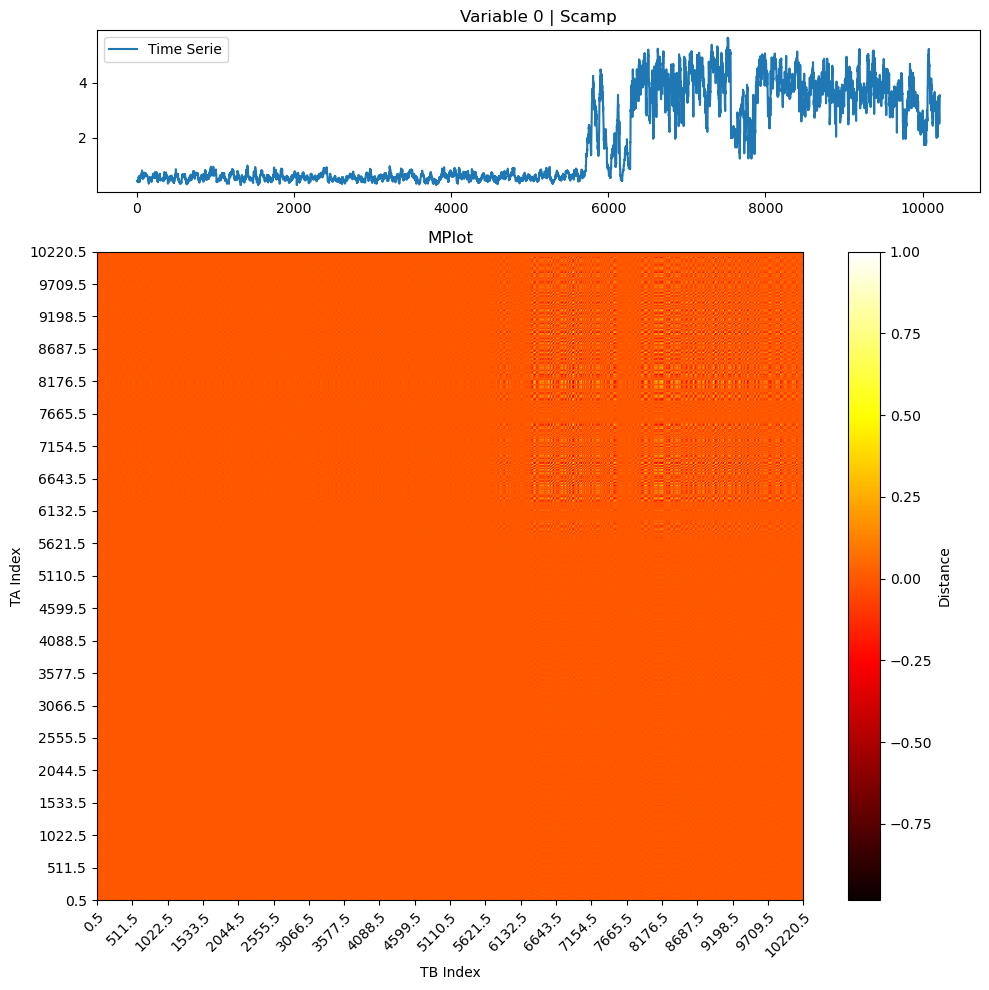

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [ ]:
data_MPlot.plot(
    ts_name     = 'Variable 0',
    method      = 'Scamp',
    figsize     = (10,10),
    print_flag  = True,
    less_labels = True 
)

In [ ]:
def rescale_index(
    index        : int,
    min_position : int, 
    max_points   : int = 10000,
    n_timestamps : int = 10000
) -> int:
    return min_position + np.floor(index * n_timestamps // max_points).astype(int)

In [ ]:
print(rescale_index(7665, max_points, n_timestamps))
print(rescale_index(8176, max_points, n_timestamps))

11495
11595


In [ ]:
fraction = 205000/4
print(fraction)
approximated_position_in_eamonn_plot = fraction + (2 * fraction / 3)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

51250.0
Approximated position in eammon's plot 85416.66666666666
